In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

import random
import numpy as np
import torch


from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
)

from monai.config import print_config
from monai.metrics import DiceMetric
# from src.models.swincspunetr import SwinCSPUNETR
# from src.models.swincspunetr_unet import SwinCSPUNETR_unet
# from src.models.swincspunetr3plus import SwinCSPUNETR3plus

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

# 랜덤 시드 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


print_config()

c:\Users\pook0\.conda\envs\UM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.4.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: c:\Users\<username>\.conda\envs\UM\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: 5.2.0
TorchVision version: 0.19.1+cu121
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.0.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: 2.17.2
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.

In [2]:
# class_info = {
#     0: {"name": "background", "weight": 0},  # weight 없음
#     1: {"name": "apo-ferritin", "weight": 1000},
#     2: {"name": "beta-amylase", "weight": 100}, # 4130
#     3: {"name": "beta-galactosidase", "weight": 1500}, #3080
#     4: {"name": "ribosome", "weight": 1000},
#     5: {"name": "thyroglobulin", "weight": 1500},
#     6: {"name": "virus-like-particle", "weight": 1000},
# }

# # 가중치에 비례한 비율 계산
# raw_ratios = {
#     k: (v["weight"] if v["weight"] is not None else 0.01)  # 가중치 비례, None일 경우 기본값a
#     for k, v in class_info.items()
# }
# total = sum(raw_ratios.values())
# ratios = {k: v / total for k, v in raw_ratios.items()}

# # 최종 합계가 1인지 확인
# final_total = sum(ratios.values())
# print("클래스 비율:", ratios)
# print("최종 합계:", final_total)

# # 비율을 리스트로 변환
# ratios_list = [ratios[k] for k in sorted(ratios.keys())]
# print("클래스 비율 리스트:", ratios_list)

# 모델 설정

In [3]:
from src.dataset.dataset import create_dataloaders, create_dataloaders_bw
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, NormalizeIntensityd,
    Orientationd, CropForegroundd, GaussianSmoothd, ScaleIntensityd,
    RandSpatialCropd, RandRotate90d, RandFlipd, RandGaussianNoised,
    ToTensord, RandCropByLabelClassesd, RandCropByPosNegLabeld, RandCropd, RandSpatialCrop,
)
from monai.transforms import CastToTyped
import numpy as np

train_img_dir = "./denoised_datasets/train/images"
train_label_dir = "./denoised_datasets/train/labels"
val_img_dir = "./denoised_datasets/val/images"
val_label_dir = "./denoised_datasets/val/labels"
# DATA CONFIG
img_size =  96 # Match your patch size
img_depth = img_size
n_classes = 256
batch_size = 16 # 13.8GB GPU memory required for 128x128 img size
loader_batch = 1
num_samples = batch_size // loader_batch # 한 이미지에서 뽑을 샘플 수
num_repeat = 4
# MODEL CONFIG
num_epochs = 4000
lamda = 0.5
ce_weight = 0.4
lr = 0.001
feature_size = 48
use_checkpoint = True
use_v2 = True
drop_rate= 0.25
attn_drop_rate = 0.25
num_bottleneck = 2
# CLASS_WEIGHTS
class_weights = None
# class_weights = torch.tensor([0.0001, 1, 0.001, 1.1, 1, 1.1, 1], dtype=torch.float32)  # 클래스별 가중치
sigma = 2.0
accumulation_steps = 1
# INIT
start_epoch = 0
best_val_loss = float('inf')
best_val_fbeta_score = 0

non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
])
val_non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
])
random_transforms = Compose([
    RandCropd(
        keys=["image", "label"],
        cropper=RandSpatialCrop(roi_size=[img_depth, img_size, img_size], random_center=True, random_size=False)
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
])


In [4]:
train_loader, val_loader = None, None
train_loader, val_loader = create_dataloaders(
    train_img_dir, 
    train_label_dir, 
    val_img_dir, 
    val_label_dir, 
    non_random_transforms = non_random_transforms, 
    random_transforms = random_transforms, 
    batch_size = loader_batch,
    num_workers=0,train_num_repeat=num_repeat)

Loading dataset: 100%|██████████| 1/1 [00:00<00:00,  8.85it/s]


https://monai.io/model-zoo.html

In [5]:
from monai.losses import TverskyLoss
import torch
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

In [6]:
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import torch
from pathlib import Path
from monai.networks.nets import UNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=n_classes,
    channels=(48, 64, 80, 80),
    strides=(2, 2, 1),
    num_res_units=1,
    dropout = drop_rate,
).to(device)

pretrain_str = "yes" if use_checkpoint else "no"
weight_str = "weighted" if class_weights is not None else ""

# 체크포인트 디렉토리 및 파일 설정
checkpoint_base_dir = Path("./model_checkpoints")
folder_name = f"Denoising_UNet_{weight_str}_f{feature_size}_d{img_depth}s{img_size}_numb{num_bottleneck}_lr{lr:.0e}_a{lamda:.2f}_b{1-lamda:.2f}_b{batch_size}_r{num_repeat}_ce{ce_weight}_ac{accumulation_steps}"
checkpoint_dir = checkpoint_base_dir / folder_name
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
# 체크포인트 디렉토리 생성
checkpoint_dir.mkdir(parents=True, exist_ok=True)

if checkpoint_dir.exists():
    best_model_path = checkpoint_dir / 'best_model.pt'
    if best_model_path.exists():
        print(f"기존 best model 발견: {best_model_path}")
        try:
            checkpoint = torch.load(best_model_path, map_location=device)
            # 체크포인트 내부 키 검증
            required_keys = ['model_state_dict', 'optimizer_state_dict', 'epoch', 'best_val_loss']
            if all(k in checkpoint for k in required_keys):
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                start_epoch = checkpoint['epoch']
                best_val_loss = checkpoint['best_val_loss']
                print("기존 학습된 가중치를 성공적으로 로드했습니다.")
                checkpoint= None
            else:
                raise ValueError("체크포인트 파일에 필요한 key가 없습니다.")
        except Exception as e:
            print(f"체크포인트 파일을 로드하는 중 오류 발생: {e}")

In [7]:
batch = next(iter(val_loader))
images, labels = batch["image"], batch["label"]
print(images.shape, labels.shape)

torch.Size([1, 1, 96, 96, 96]) torch.Size([1, 1, 96, 96, 96])


In [8]:
torch.backends.cudnn.benchmark = True

In [9]:
import wandb
from datetime import datetime

current_time = datetime.now().strftime('%Y%m%d_%H%M%S')
run_name = folder_name

# wandb 초기화
wandb.init(
    project='czii',  # 프로젝트 이름 설정
    name=run_name,         # 실행(run) 이름 설정
    config={
        'num_epochs': num_epochs,
        'learning_rate': lr,
        'batch_size': batch_size,
        'lambda': lamda,
        "cross_entropy_weight": ce_weight,
        'feature_size': feature_size,
        'img_size': img_size,
        # 'sampling_ratio': ratios_list,
        'device': device.type,
        "checkpoint_dir": str(checkpoint_dir),
        "class_weights": class_weights.tolist() if class_weights is not None else None,
        "use_checkpoint": use_checkpoint,
        "drop_rate": drop_rate,
        "attn_drop_rate": attn_drop_rate,
        "use_v2": use_v2,
        "accumulation_steps": accumulation_steps,
        "num_repeat": num_repeat,
        "num_bottleneck": num_bottleneck,
        
        # 필요한 하이퍼파라미터 추가
    }
)
# 모델을 wandb에 연결
wandb.watch(model, log='all')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: pook0612 (limbw). Use `wandb login --relogin` to force relogin


# 학습

In [ ]:
# from monai.metrics import DiceMetric
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
    
def processing(batch_data, model, criterion, device):
    images = batch_data['image'].to(device)  # Input 이미지 (B, 1, 96, 96, 96)
    labels = batch_data['label'].to(device)  # 라벨 (B, 96, 96, 96)
    
    # print("shape:", images.shape, labels.shape)

    labels = labels.squeeze(1)  # (B, 1, 96, 96, 96) → (B, 96, 96, 96)
    labels = labels.long()  # 라벨을 정수형으로 변환
    # print("shape:", images.shape, labels.shape)
    # 원핫 인코딩 (B, H, W, D) → (B, num_classes, H, W, D)
    
    # labels_onehot = torch.nn.functional.one_hot(labels, num_classes=n_classes)
    # labels_onehot = labels_onehot.permute(0, 4, 1, 2, 3).float()  # (B, num_classes, H, W, D)
    # print("shape:", images.shape, labels_onehot.shape)
    # 모델 예측
    outputs = model(images)  # outputs: (B, num_classes, H, W, D)
    # print("output shape:", outputs.shape)  

    # Loss 계산
    loss = criterion(outputs, labels)
    # loss = loss_fn(criterion(outputs, labels_onehot),class_weights=class_weights, device=device)
    return loss, outputs, labels, outputs.argmax(dim=1)

def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, accumulation_steps=4):
    model.train()
    epoch_loss = 0
    optimizer.zero_grad()  # 그래디언트 초기화
    with tqdm(train_loader, desc='Training') as pbar:
        for i, batch_data in enumerate(pbar):
            # 손실 계산
            loss, _, _, _ = processing(batch_data, model, criterion, device)

            # 그래디언트를 계산하고 누적
            loss = loss / accumulation_steps  # 그래디언트 누적을 위한 스케일링
            loss.backward()  # 그래디언트 계산 및 누적
            
            # 그래디언트 업데이트 (accumulation_steps마다 한 번)
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()  # 파라미터 업데이트
                optimizer.zero_grad()  # 누적된 그래디언트 초기화
            
            # 손실값 누적 (스케일링 복구)
            epoch_loss += loss.item() * accumulation_steps  # 실제 손실값 반영
            pbar.set_postfix(loss=loss.item() * accumulation_steps)  # 실제 손실값 출력
    avg_loss = epoch_loss / len(train_loader)
    wandb.log({'train_epoch_loss': avg_loss, 'epoch': epoch + 1})
    return avg_loss

def calculate_psnr_ssim(pred, target):
    """
    PSNR과 SSIM을 계산하는 함수
    pred: 예측 이미지 (numpy 배열)
    target: 실제 이미지 (numpy 배열)
    """
    pred_np = pred.cpu().numpy()
    target_np = target.cpu().numpy()
    
    # print("pred min max:", pred_np.min(), pred_np.max())
    # print("target min max:", target_np.min(), target_np.max())
    
    psnr_value = psnr(target_np, pred_np, data_range=target_np.max() - target_np.min())
    # ssim_value, _ = ssim(target_np, pred_np, data_range=target_np.max() - target_np.min(), full=True)
    
    return psnr_value, 0

def validate_one_epoch(model, val_loader, criterion, device, epoch, calculate_dice_interval):
    model.eval()
    val_loss = 0
    
    class_psnr_scores = {i: [] for i in range(n_classes)}
    class_ssim_scores = {i: [] for i in range(n_classes)}
    with torch.no_grad():
        with tqdm(val_loader, desc='Validation') as pbar:
            for batch_data in pbar:
                loss, _, labels, preds = processing(batch_data, model, criterion, device)
                val_loss += loss.item()
                pbar.set_postfix(loss=loss.item())

                # 각 클래스별 Dice 점수 계산
                if epoch % calculate_dice_interval == 0:
                    for i in range(n_classes):
                        pred_i = (preds == i).float()
                        label_i = (labels == i).float()
                        
                        psnr_value, ssim_value = calculate_psnr_ssim(pred_i, label_i)
                        class_psnr_scores[i].append(psnr_value)
                        class_ssim_scores[i].append(ssim_value)
                        # PSNR, SSIM 값을 로깅
                        wandb.log({f'class_{i}_psnr': psnr_value, 'epoch': epoch + 1})
                        wandb.log({f'class_{i}_ssim': ssim_value, 'epoch': epoch + 1})
                        # print(f"Class {i}: PSNR: {psnr_value:.4f}, SSIM: {ssim_value:.4f}", end=", ")
                            

    avg_loss = val_loss / len(val_loader)
    # 에포크별 평균 손실 로깅
    wandb.log({'val_epoch_loss': avg_loss, 'epoch': epoch + 1})
    
    if epoch % calculate_dice_interval == 0:
        print("Validation PSNR and SSIM Scores")
        all_classes_psnr_scores = []
        all_classes_ssim_scores = []
        for i in range(n_classes):
            psnr_value = np.mean(class_psnr_scores[i])
            ssim_value = np.mean(class_ssim_scores[i])
            # wandb.log({f'class_{i}_psnr': psnr_value, 'epoch': epoch + 1})
            # wandb.log({f'class_{i}_ssim': ssim_value, 'epoch': epoch + 1})
            # print(f"Class {i}: PSNR: {psnr_value:.4f}, SSIM: {ssim_value:.4f}", end=", ")
            if i not in [0, 2]:  # 평균에 포함할 클래스만 추가
                all_classes_psnr_scores.append(psnr_value)
                all_classes_ssim_scores.append(ssim_value)
        print()
        overall_mean_psnr = np.mean(all_classes_psnr_scores)
        overall_mean_ssim = np.mean(all_classes_ssim_scores)
        # wandb.log({'overall_mean_psnr': overall_mean_psnr, 'overall_mean_ssim': overall_mean_ssim, 'epoch': epoch + 1})
        print(f"\nOverall Mean PSNR: {overall_mean_psnr:.4f}\nOverall Mean SSIM: {overall_mean_ssim:.4f}\n")

    # if overall_mean_fbeta is None:
    #     overall_mean_fbeta = 0

    # 시각화 코드
    # 예측과 라벨을 시각화
    
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    preds = np.squeeze(preds, axis=0)
    labels = np.squeeze(labels, axis=0)
    # print(preds.shape, labels.shape)
    
    slice_idx = 50
    plt.figure(figsize=(10, 5))

    # Image 1 비교
    plt.subplot(1, 2, 1)
    plt.imshow(preds[slice_idx], cmap="gray")
    plt.title("Image: Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(labels[slice_idx], cmap="gray")
    plt.title("Label: denoised")
    plt.axis("off")
    plt.show()
    
    return val_loss / len(val_loader), overall_mean_psnr, overall_mean_ssim

def train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs, patience, 
    device, start_epoch, best_val_loss, best_val_fbeta_score, calculate_dice_interval=1,
    accumulation_steps=4
):
    """
    모델을 학습하고 검증하는 함수
    Args:
        model: 학습할 모델
        train_loader: 학습 데이터 로더
        val_loader: 검증 데이터 로더
        criterion: 손실 함수
        optimizer: 최적화 알고리즘
        num_epochs: 총 학습 epoch 수
        patience: early stopping 기준
        device: GPU/CPU 장치
        start_epoch: 시작 epoch
        best_val_loss: 이전 최적 validation loss
        best_val_fbeta_score: 이전 최적 validation f-beta score
        calculate_dice_interval: Dice 점수 계산 주기
    """
    epochs_no_improve = 0

    for epoch in range(start_epoch, num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Train One Epoch
        train_loss = train_one_epoch(
            model=model, 
            train_loader=train_loader, 
            criterion=criterion, 
            optimizer=optimizer, 
            device=device,
            epoch=epoch,
            accumulation_steps= accumulation_steps
        )
        
        scheduler.step(train_loss)
        # Validate One Epoch
        val_loss, overall_mean_psnr, overall_mean_ssim = validate_one_epoch(
            model=model, 
            val_loader=val_loader, 
            criterion=criterion, 
            device=device, 
            epoch=epoch, 
            calculate_dice_interval=calculate_dice_interval
        )

        
        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation PSNR: {overall_mean_psnr:.4f}")

        if val_loss < best_val_loss and overall_mean_psnr > best_val_fbeta_score:
            best_val_loss = val_loss
            best_val_fbeta_score = overall_mean_psnr
            epochs_no_improve = 0
            checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pt')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_fbeta_score': best_val_fbeta_score
            }, checkpoint_path)
            print(f"========================================================")
            print(f"SUPER Best model saved. Loss:{best_val_loss:.4f}, Score:{best_val_fbeta_score:.4f}")
            print(f"========================================================")

        # Early stopping 조건 체크
        if val_loss >= best_val_loss and overall_mean_psnr <= best_val_fbeta_score:
            epochs_no_improve += 1
        else:
            epochs_no_improve = 0

        if epochs_no_improve >= patience:
            print("Early stopping")
            checkpoint_path = os.path.join(checkpoint_dir, 'last.pt')
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'best_val_fbeta_score': best_val_fbeta_score
            }, checkpoint_path)
            break
        # if epochs_no_improve%6 == 0 & epochs_no_improve != 0:
        #     # 손실이 개선되지 않았으므로 lambda 감소
        #     new_lamda = max(criterion.lamda - 0.01, 0.35)  # 최소값은 0.1로 설정
        #     criterion.set_lamda(new_lamda)
        #     print(f"Validation loss did not improve. Reducing lambda to {new_lamda:.4f}")

    wandb.finish()


Epoch 1/4000


Validation:   0%|          | 0/3 [00:00<?, ?it/s, loss=4.28]c:\Users\pook0\.conda\envs\UM\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: invalid value encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min m

Validation:  33%|███▎      | 1/3 [00:01<00:03,  1.72s/it, loss=4.09]

pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min m

Validation:  67%|██████▋   | 2/3 [00:03<00:01,  1.73s/it, loss=4.12]

pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min m

Validation: 100%|██████████| 3/3 [00:05<00:00,  1.73s/it, loss=4.12]

 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
pred min max: 0.0 0.0
target min max: 0.0 0.0
Validation PSNR and SSIM Scores


Overall Mean PSNR: nan
Overall Mean SSIM: 0.0000



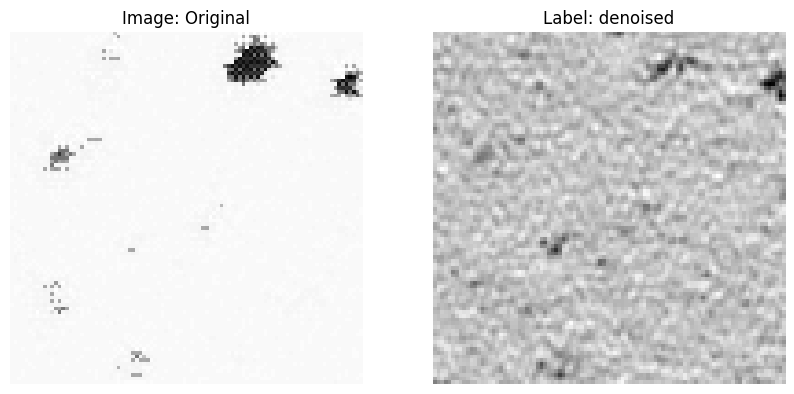

Training Loss: 4.5859, Validation Loss: 4.1611, Validation PSNR: nan
Epoch 2/4000


Training:  67%|██████▋   | 16/24 [00:11<00:05,  1.43it/s, loss=3.82]

In [ ]:
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    patience=5,
    device=device,
    start_epoch=start_epoch,
    best_val_loss=best_val_loss,
    best_val_fbeta_score=best_val_fbeta_score,
    calculate_dice_interval=1,
    accumulation_steps = accumulation_steps
     ) 

In [ ]:
if:

SyntaxError: invalid syntax (879943805.py, line 1)

# VAl

In [ ]:
from monai.data import DataLoader, Dataset, CacheDataset
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, NormalizeIntensityd,
    Orientationd, CropForegroundd, GaussianSmoothd, ScaleIntensityd,
    RandSpatialCropd, RandRotate90d, RandFlipd, RandGaussianNoised,
    ToTensord, RandCropByLabelClassesd
)
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR, SwinUNETR
from monai.losses import TverskyLoss
import torch
import numpy as np
from tqdm import tqdm
import wandb
from src.dataset.dataset import make_val_dataloader

val_img_dir = "./datasets/val/images"
val_label_dir = "./datasets/val/labels"
img_depth = 96
img_size = 96  # Match your patch size
n_classes = 7
batch_size = 2 # 13.8GB GPU memory required for 128x128 img size
num_samples = batch_size # 한 이미지에서 뽑을 샘플 수
loader_batch = 1
lamda = 0.52

wandb.init(
    project='czii_SwinUnetR_val',  # 프로젝트 이름 설정
    name='SwinUNETR96_96_lr0.001_lambda0.52_batch2',         # 실행(run) 이름 설정
    config={
        'learning_rate': 0.001,
        'batch_size': batch_size,
        'lambda': lamda,
        'img_size': img_size,
        'device': 'cuda',
        "checkpoint_dir": "./model_checkpoints/SwinUNETR96_96_lr0.001_lambda0.52_batch2",
        
    }
)

non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image", "label"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image", "label"], axcodes="RAS"),
    GaussianSmoothd(
        keys=["image"],      # 변환을 적용할 키
        sigma=[1.0, 1.0, 1.0]  # 각 축(x, y, z)의 시그마 값
        ),
])
random_transforms = Compose([
    RandCropByLabelClassesd(
        keys=["image", "label"],
        label_key="label",
        spatial_size=[img_depth, img_size, img_size],
        num_classes=n_classes,
        num_samples=num_samples, 
        ratios=ratios_list,
    ),
    RandRotate90d(keys=["image", "label"], prob=0.5, spatial_axes=[1, 2]),
    RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
])

val_loader = make_val_dataloader(
    val_img_dir, 
    val_label_dir, 
    non_random_transforms = non_random_transforms, 
    random_transforms = random_transforms, 
    batch_size = loader_batch,
    num_workers=0
)
criterion = TverskyLoss(
    alpha= 1 - lamda,  # FP에 대한 가중치
    beta=lamda,       # FN에 대한 가중치
    include_background=False,  # 배경 클래스 제외
    softmax=True
)
    
    
from monai.metrics import DiceMetric

img_size = 96
img_depth = img_size
n_classes = 7 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrain_path = "./model_checkpoints/SwinUNETR96_96_lr0.001_lambda0.52_batch2/best_model.pt"
model = SwinUNETR(
    img_size=(img_depth, img_size, img_size),
    in_channels=1,
    out_channels=n_classes,
    feature_size=48,
    use_checkpoint=True,
).to(device)
# Pretrained weights 불러오기
checkpoint = torch.load(pretrain_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

val_loss, overall_mean_fbeta_score = validate_one_epoch(
    model=model, 
    val_loader=val_loader, 
    criterion=criterion, 
    device=device, 
    epoch=0, 
    calculate_dice_interval=1
)

class_0_dice_score,▁
class_0_f_beta_score,▁
class_1_dice_score,▁
class_1_f_beta_score,▁
class_2_dice_score,▁
class_2_f_beta_score,▁
class_3_dice_score,▁
class_3_f_beta_score,▁
class_4_dice_score,▁
class_4_f_beta_score,▁
class_5_dice_score,▁


Loading dataset: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it]
C:\Users\Seungwoo\AppData\Local\Temp\ipykernel_21000\1177025787.py:95: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feat

Validation Dice Score
Class 0: 0.6570, Class 1: 0.5333, Class 2: 0.0029, Class 3: 0.2370, 
Class 4: 0.6549, Class 5: 0.4790, Class 6: 0.4255, 
Validation F-beta Score
Class 0: 0.5075, Class 1: 0.6470, Class 2: 0.0233, Class 3: 0.2303, 
Class 4: 0.6252, Class 5: 0.5145, Class 6: 0.4720, 
Overall Mean Dice Score: 0.4659
Overall Mean F-beta Score: 0.4978



# Inference

In [ ]:
from src.dataset.preprocessing import Preprocessor

In [ ]:
from monai.inferers import sliding_window_inference
from monai.transforms import Compose, EnsureChannelFirstd, NormalizeIntensityd, Orientationd, GaussianSmoothd
from monai.data import DataLoader, Dataset, CacheDataset
from monai.networks.nets import SwinUNETR
from pathlib import Path
import numpy as np
import copick

import torch
print("Done.")

Done.


In [ ]:
config_blob = """{
    "name": "czii_cryoet_mlchallenge_2024",
    "description": "2024 CZII CryoET ML Challenge training data.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "apo-ferritin",
            "is_particle": true,
            "pdb_id": "4V1W",
            "label": 1,
            "color": [  0, 117, 220, 128],
            "radius": 60,
            "map_threshold": 0.0418
        },
        {
          "name" : "beta-amylase",
            "is_particle": true,
            "pdb_id": "8ZRZ",
            "label": 2,
            "color": [255, 255, 255, 128],
            "radius": 90,
            "map_threshold": 0.0578  
        },
        {
            "name": "beta-galactosidase",
            "is_particle": true,
            "pdb_id": "6X1Q",
            "label": 3,
            "color": [ 76,   0,  92, 128],
            "radius": 90,
            "map_threshold": 0.0578
        },
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "6EK0",
            "label": 4,
            "color": [  0,  92,  49, 128],
            "radius": 150,
            "map_threshold": 0.0374
        },
        {
            "name": "thyroglobulin",
            "is_particle": true,
            "pdb_id": "6SCJ",
            "label": 5,
            "color": [ 43, 206,  72, 128],
            "radius": 130,
            "map_threshold": 0.0278
        },
        {
            "name": "virus-like-particle",
            "is_particle": true,
            "label": 6,
            "color": [255, 204, 153, 128],
            "radius": 135,
            "map_threshold": 0.201
        },
        {
            "name": "membrane",
            "is_particle": false,
            "label": 8,
            "color": [100, 100, 100, 128]
        },
        {
            "name": "background",
            "is_particle": false,
            "label": 9,
            "color": [10, 150, 200, 128]
        }
    ],

    "overlay_root": "./kaggle/working/overlay",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "static_root": "./kaggle/input/czii-cryo-et-object-identification/test/static"
}"""

copick_config_path = "./kaggle/working/copick.config"
preprocessor = Preprocessor(config_blob,copick_config_path=copick_config_path)
non_random_transforms = Compose([
    EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
    NormalizeIntensityd(keys="image"),
    Orientationd(keys=["image"], axcodes="RAS"),
    GaussianSmoothd(
        keys=["image"],      # 변환을 적용할 키
        sigma=[1.0, 1.0, 1.0]  # 각 축(x, y, z)의 시그마 값
        ),
    ])

Config file written to ./kaggle/working/copick.config
file length: 7


In [ ]:
img_size = 96
img_depth = img_size
n_classes = 7 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrain_path = "./model_checkpoints/SwinUNETR96_96_lr0.001_lambda0.52_batch2/best_model.pt"
model = SwinUNETR(
    img_size=(img_depth, img_size, img_size),
    in_channels=1,
    out_channels=n_classes,
    feature_size=48,
    use_checkpoint=True,
).to(device)
# Pretrained weights 불러오기
checkpoint = torch.load(pretrain_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])


c:\ProgramData\anaconda3\envs\ship\Lib\site-packages\monai\utils\deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)
C:\Users\Seungwoo\AppData\Local\Temp\ipykernel_6248\2937359115.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will

<All keys matched successfully>

In [ ]:
val_loss = validate_one_epoch(
            model=model, 
            val_loader=val_loader, 
            criterion=criterion, 
            device=device, 
            epoch=1, 
            calculate_dice_interval=0
        )

Validation:   0%|          | 0/4 [00:03<?, ?it/s, loss=0.764]


ZeroDivisionError: integer modulo by zero

In [ ]:
import torch
import numpy as np
from scipy.ndimage import label, center_of_mass
import pandas as pd
from tqdm import tqdm
from monai.data import CacheDataset, DataLoader
from monai.transforms import Compose, NormalizeIntensity
import cc3d

def dict_to_df(coord_dict, experiment_name):
    all_coords = []
    all_labels = []
    
    for label, coords in coord_dict.items():
        all_coords.append(coords)
        all_labels.extend([label] * len(coords))
    
    all_coords = np.vstack(all_coords)
    df = pd.DataFrame({
        'experiment': experiment_name,
        'particle_type': all_labels,
        'x': all_coords[:, 0],
        'y': all_coords[:, 1],
        'z': all_coords[:, 2]
    })
    return df

id_to_name = {1: "apo-ferritin", 
              2: "beta-amylase",
              3: "beta-galactosidase", 
              4: "ribosome", 
              5: "thyroglobulin", 
              6: "virus-like-particle"}
BLOB_THRESHOLD = 200
CERTAINTY_THRESHOLD = 0.05

classes = [1, 2, 3, 4, 5, 6]

model.eval()
with torch.no_grad():
    location_dfs = []  # DataFrame 리스트로 초기화
    
    for vol_idx, run in enumerate(preprocessor.root.runs):
        print(f"Processing volume {vol_idx + 1}/{len(preprocessor.root.runs)}")
        tomogram = preprocessor.processing(run=run, task="task")
        task_files = [{"image": tomogram}]
        task_ds = CacheDataset(data=task_files, transform=non_random_transforms)
        task_loader = DataLoader(task_ds, batch_size=1, num_workers=0)
        
        for task_data in task_loader:
            images = task_data['image'].to("cuda")
            outputs = sliding_window_inference(
                inputs=images,
                roi_size=(96, 96, 96),  # ROI 크기
                sw_batch_size=4,
                predictor=model.forward,
                overlap=0.1,
                sw_device="cuda",
                device="cpu",
                buffer_steps=1,
                buffer_dim=-1
            )
            outputs = outputs.argmax(dim=1).squeeze(0).cpu().numpy()  # 클래스 채널 예측
            location = {}  # 좌표 저장용 딕셔너리
            for c in classes:
                cc = cc3d.connected_components(outputs == c)  # cc3d 라벨링
                stats = cc3d.statistics(cc)
                zyx = stats['centroids'][1:] * 10.012444  # 스케일 변환
                zyx_large = zyx[stats['voxel_counts'][1:] > BLOB_THRESHOLD]  # 크기 필터링
                xyz = np.ascontiguousarray(zyx_large[:, ::-1])  # 좌표 스왑 (z, y, x -> x, y, z)

                location[id_to_name[c]] = xyz  # ID 이름 매칭 저장

            # 데이터프레임 변환
            df = dict_to_df(location, run.name)
            location_dfs.append(df)  # 리스트에 추가
        
        # if vol_idx == 2:
        #     break
    
    # DataFrame 병합
    final_df = pd.concat(location_dfs, ignore_index=True)
    
    # ID 추가 및 CSV 저장
    final_df.insert(loc=0, column='id', value=np.arange(len(final_df)))
    final_df.to_csv("submission.csv", index=False)
    print("Submission saved to: submission.csv")


Processing volume 1/7


Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]


Processing volume 2/7


Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


Processing volume 3/7


Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Submission saved to: submission.csv
